In [2]:
!pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/949.2 kB ? eta -:--:--
     ---------------------------------------- 949.2/949.2 kB 3.5 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   -------------------------------- ------- 1.3/1.6 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 5.1 MB/s  0:00:00
  Created wheel for multitasking: filename=multita

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam

C:\Users\bbuser\AppData\Local\Temp\ipykernel_11960\3852018687.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


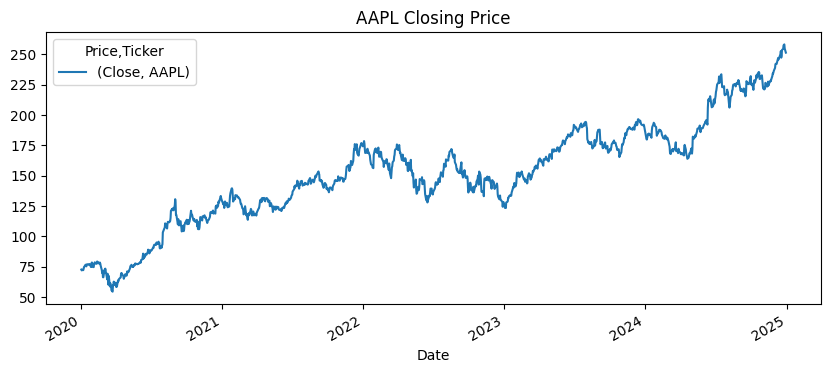

In [4]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
data = data[['Close']]
data.plot(title='AAPL Closing Price', figsize=(10,4))
plt.show()

In [5]:
window_size = 30  # number of days to look back
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [6]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
ff_model = Sequential([
    Dense(64, activation='relu', input_shape=(window_size,)),
    Dense(32, activation='relu'),
    Dense(1)
])

ff_model.compile(optimizer=Adam(0.001), loss='mae')
ff_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

C:\Users\bbuser\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
ff_pred = ff_model.predict(X_test)
ff_mae = mean_absolute_error(y_test, ff_pred)
print("Feedforward MAE:", ff_mae)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Feedforward MAE: 0.013896599264971669


In [9]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(0.001), loss='mae')
lstm_model.fit(X_train_rnn, y_train, epochs=30, batch_size=32, verbose=0)

C:\Users\bbuser\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
lstm_pred = lstm_model.predict(X_test_rnn)
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("LSTM MAE:", lstm_mae)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
LSTM MAE: 0.015667014873510368


In [12]:
gru_model = Sequential([
    GRU(64, input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(0.001), loss='mae')
gru_model.fit(X_train_rnn, y_train, epochs=30, batch_size=32, verbose=0)

gru_pred = gru_model.predict(X_test_rnn)
gru_mae = mean_absolute_error(y_test, gru_pred)
print("GRU MAE:", gru_mae)


C:\Users\bbuser\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
GRU MAE: 0.011183267486100509


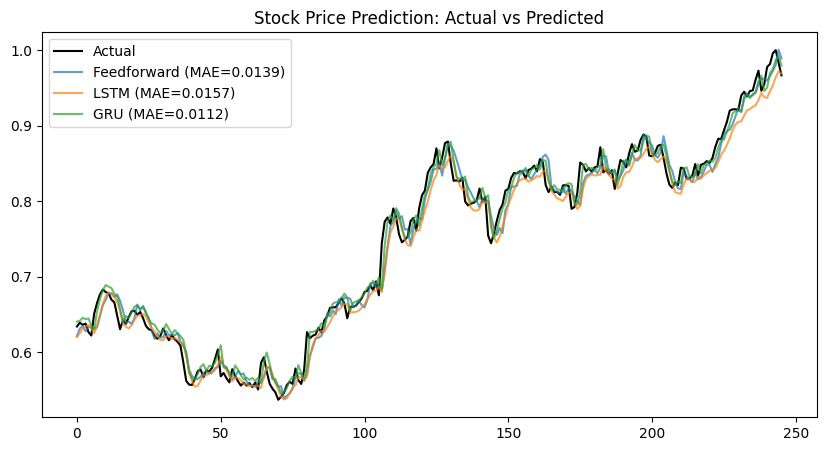

In [13]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual', color='black')
plt.plot(ff_pred, label=f'Feedforward (MAE={ff_mae:.4f})', alpha=0.7)
plt.plot(lstm_pred, label=f'LSTM (MAE={lstm_mae:.4f})', alpha=0.7)
plt.plot(gru_pred, label=f'GRU (MAE={gru_mae:.4f})', alpha=0.7)
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()